# Analyzing Cancelled Tesla Orders

In [ ]:
from collections import Counter
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from pprint import pprint
import re
import seaborn as sns
from wordcloud import WordCloud
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Collect the data

# Read the cancelled Tesla orders into a data frame
tco = pd.read_csv("/teslacancelledorders.csv")

# Print the data frame
tco.head()

,Unnamed: 0,date,tweet_url,tweet_content,tweet_rendered_content,tweet_id,user_name,display_name,user_id,concatenated_profile_url,...,tweet_reply_count,tweet_retweet_count,tweet_like_count,tweet_quote_count,tweet_language,tweet_source,rt_original_tweet_id,quoted_tweet_original_tweet_id,tweet_mentioned_users,tweet_hashtags
0,0,2022-12-15 18:42:14+00:00,https://twitter.com/jessica_anwyn/status/16034...,@sacwriter Asked a close friend who has had 3 ...,@sacwriter Asked a close friend who has had 3 ...,1603460441555935232,jessica_anwyn,🏳️‍⚧️ Jessica 🏳️‍⚧️,1395971032935063562,https://twitter.com/jessica_anwyn,...,1,0,1,0,en,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,"[User(username='sacwriter', id=806532993808334...",NaN
1,1,2022-12-15 18:39:56+00:00,https://twitter.com/World_ly/status/1603459860...,@tkulzer @arcjean @Tesla I cancelled my order ...,@tkulzer @arcjean @Tesla I cancelled my order ...,1603459860393123840,World_ly,David B. Landes. Telling it like it is.,1629608972,https://twitter.com/World_ly,...,0,0,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,"[User(username='tkulzer', id=14173044, display...",NaN
2,2,2022-12-15 17:24:57+00:00,https://twitter.com/Siouxtopia_ACNH/status/160...,@StarkJoakim @JohnHanzl @TSLAFanMtl @garyblack...,@StarkJoakim @JohnHanzl @TSLAFanMtl @garyblack...,1603440991804923904,Siouxtopia_ACNH,Siouxtopia,1563545120296747008,https://twitter.com/Siouxtopia_ACNH,...,0,0,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,"[User(username='StarkJoakim', id=1324621989189...",NaN
3,3,2022-12-15 15:03:27+00:00,https://twitter.com/cYnborg/status/16034053835...,@bloopington I know it sounds anecdotal and yo...,@bloopington I know it sounds anecdotal and yo...,1603405383514693633,cYnborg,[xR]yan,178424476,https://twitter.com/cYnborg,...,1,0,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,"[User(username='bloopington', id=24023204, dis...",NaN
4,4,2022-12-15 12:49:51+00:00,https://twitter.com/davezatz/status/1603371760...,Tesla December delivery discount. Looks like t...,Tesla December delivery discount. Looks like t...,1603371760543490052,davezatz,Dave Zatz,14222615,https://twitter.com/davezatz,...,2,0,1,0,en,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN


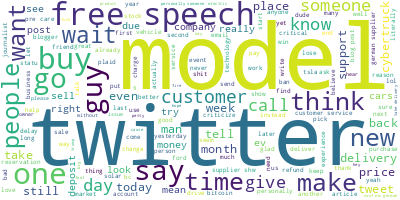

In [ ]:
# Clean the data

# Remove unnecessary columns
tco.drop(columns = ['tweet_url', 'tweet_content', 'tweet_id', 'user_name', 'display_name', 'user_id', 'concatenated_profile_url', 'user_description', 'verified', 'user_profile_created', 'user_follower_count', 'user_friend_count', 'user_statuses_count', 'user_description_url', 'user_profile_url', 'tweet_mentioned_users', 'tweet_hashtags', 'user_profile_image_url', 'user_profile_banner_url', 'tweet_source', 'rt_original_tweet_id', 'quoted_tweet_original_tweet_id'], axis = 1, inplace = True)
tco.drop(columns = tco.columns[0], axis = 1, inplace = True)

# Filter rows to only contain tweets in English, then remove the tweet_language column
tco.loc[tco['tweet_language'] == 'en']
tco.drop(columns = ['tweet_language'], axis = 1, inplace = True)

contractions = { 
  "ain't": "am not / are not / is not / has not / have not",
  "aren't": "are not / am not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he had / he would",
  "he'd've": "he would have",
  "he'll": "he shall / he will",
  "he'll've": "he shall have / he will have",
  "he's": "he has / he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how has / how is / how does",
  "I'd": "I had / I would",
  "I'd've": "I would have",
  "I'll": "I shall / I will",
  "I'll've": "I shall have / I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had / it would",
  "it'd've": "it would have",
  "it'll": "it shall / it will",
  "it'll've": "it shall have / it will have",
  "it's": "it has / it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she shall / she will",
  "she'll've": "she shall have / she will have",
  "she's": "she has / she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as / so is",
  "that'd": "that would / that had",
  "that'd've": "that would have",
  "that's": "that has / that is",
  "there'd": "there had / there would",
  "there'd've": "there would have",
  "there's": "there has / there is",
  "they'd": "they had / they would",
  "they'd've": "they would have",
  "they'll": "they shall / they will",
  "they'll've": "they shall have / they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had / we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what shall / what will",
  "what'll've": "what shall have / what will have",
  "what're": "what are",
  "what's": "what has / what is",
  "what've": "what have",
  "when's": "when has / when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where has / where is",
  "where've": "where have",
  "who'll": "who shall / who will",
  "who'll've": "who shall have / who will have",
  "who's": "who has / who is",
  "who've": "who have",
  "why's": "why has / why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you shall have / you will have",
  "you're": "you are",
  "you've": "you have"
}

def clean_text(text):

  # Convert the text to lower case
  text = text.lower()

  # Expand contractions
  text = text.split()
  new_text = []
  for word in text:
      if word in contractions:
          new_text.append(contractions[word])
      else:
          new_text.append(word)
  text = " ".join(new_text)

  # Remove unwanted characters from the text
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags = re.MULTILINE)
  text = re.sub(r'\<a href', ' ', text)
  text = re.sub(r'&amp;', '', text) 
  text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
  text = re.sub(r'<br />', ' ', text)
  text = re.sub(r'\'', ' ', text)

  # Tokenize each word in the text
  text = nltk.WordPunctTokenizer().tokenize(text)

  # Lemmatize each word in the text
  text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos = 'v') for token in text if len(token) > 1]

  return text

def to_string(text):
  text = ' '.join(map(str, text))
  return text

# Convert each tweet into a list of its words
tco['tweet_rendered_content_clean_list'] = list(map(clean_text, tco.tweet_rendered_content))

# Convert each list of words into a string with the to_string function
tco['tweet_rendered_content_clean'] = list(map(to_string, tco['tweet_rendered_content_clean_list']))

# Create a list of stop words
stop_words = stopwords.words('english')
stop_words.extend(['tesla', 'cancel', 'order', 'tesla order', 'personally cancel', 'car', 'elon', 'musk', 'elonmusk', 'elon musk'])

tco['tweet_rendered_content_clean_list'] = [[word for word in line if word not in stop_words] for line in tco['tweet_rendered_content_clean_list']]
tco['tweet_rendered_content_clean'] = list(map(to_string, tco['tweet_rendered_content_clean_list']))

# Join all words into a comma-separated string
long_string = ','.join(list(tco['tweet_rendered_content_clean'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Explore the data

In [ ]:
# Create a dictionary
id2word = gensim.corpora.Dictionary(tco['tweet_rendered_content_clean_list'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tco['tweet_rendered_content_clean_list']]

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1, 10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, iterations = 50, num_topics = i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts = tco['tweet_rendered_content_clean_list'], dictionary = id2word, coherence = 'c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Define the number of topics 
n_topics = 4

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = n_topics, random_state = 100, update_every = 1, chunksize = 10, passes = 10, alpha = 'symmetric', iterations = 100, per_word_topics = True)

In [ ]:
# Explore words occurring in each topic with their relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.051*"com" + 0.023*"personally" + 0.017*"auto" + 0.016*"rude" + 0.012*"twitter" + 0.011*"shw" + 0.011*"super" + 0.011*"supplier" + 0.010*"man" + 0.010*"like"
Topic: 1 Word: 0.046*"model" + 0.038*"german" + 0.036*"shw" + 0.034*"supplier" + 0.032*"confirm" + 0.018*"explain" + 0.017*"motor" + 0.017*"tt" + 0.017*"ift" + 0.012*"ly"
Topic: 2 Word: 0.036*"customer" + 0.025*"one" + 0.016*"refund" + 0.013*"new" + 0.013*"deposit" + 0.012*"want" + 0.011*"000" + 0.010*"right" + 0.010*"call" + 0.009*"service"
Topic: 3 Word: 0.041*"get" + 0.018*"buy" + 0.017*"cars" + 0.012*"delivery" + 0.012*"back" + 0.011*"know" + 0.011*"time" + 0.010*"instead" + 0.010*"many" + 0.010*"due"


In [ ]:
# Visualize the data

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.168469 -0.181677       1        1  32.010282
2     -0.121057  0.167932       2        1  25.633565
0      0.079440  0.100771       3        1  25.288753
1      0.210085 -0.087026       4        1  17.067400, topic_info=          Term        Freq       Total Category  logprob  loglift
101        com  409.000000  409.000000  Default  30.0000  30.0000
82         get  419.000000  419.000000  Default  29.0000  29.0000
27       model  247.000000  247.000000  Default  28.0000  28.0000
249   customer  293.000000  293.000000  Default  27.0000  27.0000
3975    german  276.000000  276.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
6578       shw  191.644885  286.205955   Topic4  -3.3357   1.3669
6580  supplier  183.207333  273.833311   Topic4  -3.3807   1.3661
2106       jan   29.487961   35.128413   Topic4  -5.2073   1.5930
2419    berlin   26.865568   29.531593   Topic4  -5.3005   1.6734
6811  industry   33.665859   63.044016   Topic4  -5.0748   1.1407

[182 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
943       1  0.010750      000
943       2  0.989013      000
653       4  0.983363      100
6960      2  0.196496      145
6960      3  0.801097      145
...     ...       ...      ...
1703      2  0.035541    wrong
1703      3  0.959620    wrong
35        4  0.970602     year
23        4  0.955372    years
2230      4  0.955282  youtube

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

# Analyzing Elon Musk's Tweets at Peak Order Cancellation Times



In [ ]:
# Convert dates into datetime format
tco['date'] = pd.to_datetime(tco['date'], format='%Y-%m-%d')

# Sort rows by datetime
tco.sort_values(by = 'date', inplace = True)

tco['new_date'] = [d.date() for d in tco['date']]
tco['new_time'] = [d.time() for d in tco['date']]

# Print the data frame
tco.head()

,date,tweet_rendered_content,user_location,tweet_reply_count,tweet_retweet_count,tweet_like_count,tweet_quote_count,tweet_rendered_content_clean_list,tweet_rendered_content_clean,Count,new_date,new_time
2252,2009-04-02 17:55:32+00:00,Arnold Swarz drove Scorpion and cancelled his ...,"Wimberley, Texas",0,0,0,0,"[arnold, swarz, drive, scorpion]",arnold swarz drive scorpion,1,2009-04-02,17:55:32
2251,2012-09-25 12:29:31+00:00,$TSLA basically the order list is totally BOGU...,NaN,0,0,0,0,"[tsla, basically, list, totally, bogus, ask, c...",tsla basically list totally bogus ask customer...,1,2012-09-25,12:29:31
2250,2013-05-02 17:07:08+00:00,my sister cancelled her tesla order... i have ...,"Ocoee, FL",0,0,0,0,"[sister, feel, know, shes, gonna, get, instead...",sister feel know shes gonna get instead hope i...,1,2013-05-02,17:07:08
2249,2013-05-23 06:10:47+00:00,Models S Review and why he cancelled his order...,California,0,0,0,0,"[model, review, lot, detail, miss, simply, ign...",model review lot detail miss simply ignore mas...,1,2013-05-23,06:10:47
2248,2013-08-12 23:51:47+00:00,Looking to hear from Tesla fans who have cance...,Seattle,0,1,0,0,"[look, hear, fan, radar, price, hike, model, o...",look hear fan radar price hike model options p...,1,2013-08-12,23:51:47


In [ ]:
a = tco.groupby("new_date").size().values
b = tco.drop_duplicates(subset = "new_date").assign(Count = a)

b

,date,tweet_rendered_content,user_location,tweet_reply_count,tweet_retweet_count,tweet_like_count,tweet_quote_count,tweet_rendered_content_clean_list,tweet_rendered_content_clean,Count,new_date,new_time
2252,2009-04-02 17:55:32+00:00,Arnold Swarz drove Scorpion and cancelled his ...,"Wimberley, Texas",0,0,0,0,"[arnold, swarz, drive, scorpion]",arnold swarz drive scorpion,1,2009-04-02,17:55:32
2251,2012-09-25 12:29:31+00:00,$TSLA basically the order list is totally BOGU...,NaN,0,0,0,0,"[tsla, basically, list, totally, bogus, ask, c...",tsla basically list totally bogus ask customer...,1,2012-09-25,12:29:31
2250,2013-05-02 17:07:08+00:00,my sister cancelled her tesla order... i have ...,"Ocoee, FL",0,0,0,0,"[sister, feel, know, shes, gonna, get, instead...",sister feel know shes gonna get instead hope i...,1,2013-05-02,17:07:08
2249,2013-05-23 06:10:47+00:00,Models S Review and why he cancelled his order...,California,0,0,0,0,"[model, review, lot, detail, miss, simply, ign...",model review lot detail miss simply ignore mas...,1,2013-05-23,06:10:47
2248,2013-08-12 23:51:47+00:00,Looking to hear from Tesla fans who have cance...,Seattle,0,1,0,0,"[look, hear, fan, radar, price, hike, model, o...",look hear fan radar price hike model options p...,1,2013-08-12,23:51:47
...,...,...,...,...,...,...,...,...,...,...,...,...
138,2022-12-11 03:03:23+00:00,@davidmweissman @elonmusk Much like Elon cance...,NaN,1,0,0,0,"[davidmweissman, much, like, someone, get, fee...",davidmweissman much like someone get feel hurt...,13,2022-12-11,03:03:23
125,2022-12-12 00:58:12+00:00,@elonmusk I cancelled my Tesla order. And I’l...,"New Mexico, USA",0,0,2,0,"[bet, one]",bet one,39,2022-12-12,00:58:12
86,2022-12-13 00:03:25+00:00,@heathercampbell OH NO! What is Tesla going to...,NaN,0,0,0,0,"[heathercampbell, oh, go, congrats, vehicle, n...",heathercampbell oh go congrats vehicle never g...,56,2022-12-13,00:03:25
30,2022-12-14 00:08:38+00:00,@eastcoasteconom @BlackKnight10k He is anti fr...,Antarctica,0,0,0,0,"[eastcoasteconom, blackknight10k, anti, free, ...",eastcoasteconom blackknight10k anti free speec...,19,2022-12-14,00:08:38


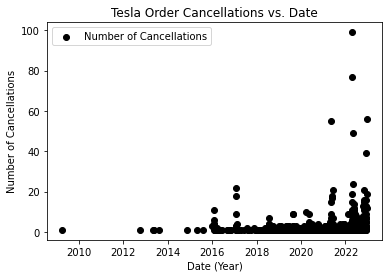

In [ ]:
# Get the variables to plot on each axis
x = b['new_date']
y = b['Count']
# Plot y vs. x in a scatter plot
plt.scatter(x, y, label = 'Number of Cancellations', color = 'black')
# Title the scatter plot and label the axes
plt.title('Tesla Order Cancellations vs. Date')
plt.xlabel('Date (Year)')
plt.ylabel('Number of Cancellations')
# Display a legend
plt.legend()
# Show the scatter plot
plt.show()

In [ ]:
b.loc[b['Count'] >= 20]

,date,tweet_rendered_content,user_location,tweet_reply_count,tweet_retweet_count,tweet_like_count,tweet_quote_count,tweet_rendered_content_clean_list,tweet_rendered_content_clean,Count,new_date,new_time
2179,2017-01-27 04:48:27+00:00,Tesla Motors confirms it cancelled order with ...,Global,0,0,0,0,"[motor, confirm, german, supplier, shw, ift, t...",motor confirm german supplier shw ift tt 2kqk1kk,22,2017-01-27,04:48:27
1551,2021-05-13 00:20:37+00:00,@APompliano @SquawkCNBC I cancelled my cyber t...,Earth for now,0,0,0,0,"[apompliano, squawkcnbc, cyber, truck, fuck]",apompliano squawkcnbc cyber truck fuck,55,2021-05-13,00:20:37
1416,2021-06-04 01:19:42+00:00,@elonmusk How about them cancelled Tesla order...,"Kerman, CA",0,0,0,0,"[china, 🇨🇳]",china 🇨🇳,21,2021-06-04,01:19:42
1035,2022-04-25 12:31:08+00:00,Imagine having so much money you can throw dow...,United Kingdom,0,0,3,0,"[imagine, much, money, throw, 45, billion, str...",imagine much money throw 45 billion stroke ego...,77,2022-04-25,12:31:08
958,2022-04-26 00:00:59+00:00,@billybinion @ecutruin From what I've heard he...,"NSW, Australia",2,2,12,0,"[billybinion, ecutruin, hear, start, take, als...",billybinion ecutruin hear start take also guy ...,99,2022-04-26,00:00:59
859,2022-04-27 00:11:56+00:00,Remember that time someone gave a critical rev...,"Pittsburgh, Pa",0,0,0,0,"[remember, time, someone, give, critical, revi...",remember time someone give critical review eve...,49,2022-04-27,00:11:56
810,2022-04-28 00:38:58+00:00,@Mlondon83 The same guy who didn’t like a post...,San Francisco Bay Area,0,0,0,0,"[mlondon83, guy, like, post, guest, make, crit...",mlondon83 guy like post guest make criticize d...,24,2022-04-28,00:38:58
320,2022-11-07 01:12:53+00:00,@BBenjaminn @Gothalion Yeah. Nobody that has e...,NaN,2,0,0,0,"[bbenjaminn, gothalion, yeah, nobody, ever, he...",bbenjaminn gothalion yeah nobody ever hear sur...,21,2022-11-07,01:12:53
125,2022-12-12 00:58:12+00:00,@elonmusk I cancelled my Tesla order. And I’l...,"New Mexico, USA",0,0,2,0,"[bet, one]",bet one,39,2022-12-12,00:58:12
86,2022-12-13 00:03:25+00:00,@heathercampbell OH NO! What is Tesla going to...,NaN,0,0,0,0,"[heathercampbell, oh, go, congrats, vehicle, n...",heathercampbell oh go congrats vehicle never g...,56,2022-12-13,00:03:25


In [ ]:
# Collect the data

# Read the cancelled Tesla orders into a data frame
emt = pd.read_csv("/elonmusktweets.csv")

# Remove unnecessary columns
emt.drop(columns = ['tweet_url', 'tweet_content', 'tweet_id', 'user_name', 'display_name', 'user_id', 'concatenated_profile_url', 'user_description', 'verified', 'user_profile_created', 'user_follower_count', 'user_friend_count', 'user_statuses_count', 'user_description_url', 'user_profile_url', 'tweet_mentioned_users', 'tweet_hashtags', 'user_profile_image_url', 'user_profile_banner_url', 'tweet_source', 'rt_original_tweet_id', 'quoted_tweet_original_tweet_id'], axis = 1, inplace = True)
emt.drop(columns = emt.columns[0], axis = 1, inplace = True)

# Convert dates into datetime format
emt['date'] = pd.to_datetime(emt['date'], format='%Y-%m-%d')

# Sort rows by datetime
emt.sort_values(by = 'date', inplace = True)

emt['new_date'] = [d.date() for d in emt['date']]
emt['new_time'] = [d.time() for d in emt['date']]

# Print the data frame
emt.head()

,date,tweet_rendered_content,user_location,tweet_reply_count,tweet_retweet_count,tweet_like_count,tweet_quote_count,tweet_language,new_date,new_time
17952,2010-06-04 18:31:57+00:00,"Please ignore prior tweets, as that was someon...",NaN,1075,642,6382,300,en,2010-06-04,18:31:57
17951,2011-12-01 09:55:11+00:00,Went to Iceland on Sat to ride bumper cars on ...,NaN,33,22,188,5,en,2011-12-01,09:55:11
17950,2011-12-01 10:29:04+00:00,I made the volume on the Model S ow.ly/i/mtD7 ...,NaN,29,13,75,7,en,2011-12-01,10:29:04
17949,2011-12-03 08:20:28+00:00,"Great Voltaire quote, arguably better than Twa...",NaN,35,31,83,6,en,2011-12-03,08:20:28
17948,2011-12-03 08:22:07+00:00,That was a total non sequitur btw,NaN,28,9,52,7,en,2011-12-03,08:22:07


In [ ]:
peak = emt.loc[((emt['date'] >= '2017-01-27') & (emt['date'] < '2017-01-28')) | (emt['date'] >= '2021-05-13') & (emt['date'] < '2021-05-14') | (emt['date'] >= '2021-06-04') & (emt['date'] < '2021-06-05') | (emt['date'] >= '2022-04-25') & (emt['date'] < '2022-04-29') | (emt['date'] >= '2022-11-07') & (emt['date'] < '2022-11-08') | (emt['date'] >= '2022-12-12') & (emt['date'] < '2022-12-14')]

<ipython-input-66-79d36464d86b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak['tweet_rendered_content_clean_list'] = list(map(clean_text, peak.tweet_rendered_content))
<ipython-input-66-79d36464d86b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak['tweet_rendered_content_clean'] = list(map(to_string, peak['tweet_rendered_content_clean_list']))
<ipython-input-66-79d36464d86b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

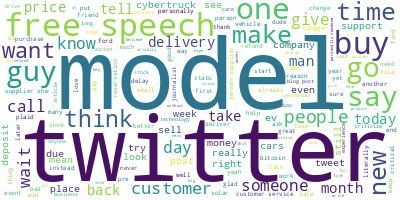

In [ ]:
# Convert each tweet into a list of its words
peak['tweet_rendered_content_clean_list'] = list(map(clean_text, peak.tweet_rendered_content))

# Convert each list of words into a string with the to_string function
peak['tweet_rendered_content_clean'] = list(map(to_string, peak['tweet_rendered_content_clean_list']))

# Create a list of stop words
stop_words = stopwords.words('english')
stop_words.extend([])

peak['tweet_rendered_content_clean_list'] = [[word for word in line if word not in stop_words] for line in peak['tweet_rendered_content_clean_list']]
peak['tweet_rendered_content_clean'] = list(map(to_string, peak['tweet_rendered_content_clean_list']))

# Join all words into a comma-separated string
long_string = ','.join(list(tco['tweet_rendered_content_clean'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score'>

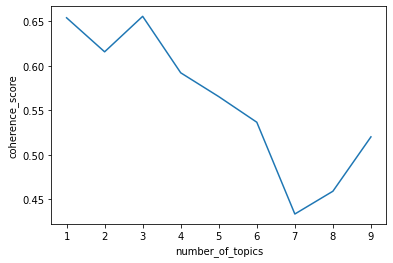

In [ ]:
# Create a dictionary
id2word = gensim.corpora.Dictionary(peak['tweet_rendered_content_clean_list'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in peak['tweet_rendered_content_clean_list']]

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1, 10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, iterations = 50, num_topics = i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts = peak['tweet_rendered_content_clean_list'], dictionary = id2word, coherence = 'c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Define the number of topics 
n_topics = 3

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = n_topics, random_state = 100, update_every = 1, chunksize = 10, passes = 10, alpha = 'symmetric', iterations = 100, per_word_topics = True)

# Explore words occurring in each topic with their relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic: 0 Word: 0.016*"real" + 0.015*"kathygriffin" + 0.015*"bennyjohnson" + 0.014*"back" + 0.012*"mattwallace888" + 0.012*"true" + 0.012*"hankgreen" + 0.010*"kylegrantham" + 0.009*"problem" + 0.007*"coca"
Topic: 1 Word: 0.026*"vote" + 0.022*"democrat" + 0.019*"party" + 0.019*"independent" + 0.016*"billym2k" + 0.013*"evafoxu" + 0.012*"actually" + 0.012*"power" + 0.012*"republican" + 0.012*"voters"
Topic: 2 Word: 0.055*"twitter" + 0.028*"bird" + 0.014*"jack" + 0.014*"source" + 0.014*"speech" + 0.012*"accurate" + 0.011*"people" + 0.011*"mean" + 0.011*"information" + 0.011*"need"


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Visualize the data

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.115407 -0.062349       1        1  39.719166
1      0.136759 -0.037090       2        1  30.188790
0     -0.021352  0.099439       3        1  30.092044, topic_info=          Term       Freq      Total Category  logprob  loglift
194    twitter  16.000000  16.000000  Default  30.0000  30.0000
491       vote   6.000000   6.000000  Default  29.0000  29.0000
463       bird   8.000000   8.000000  Default  28.0000  28.0000
505   democrat   5.000000   5.000000  Default  27.0000  27.0000
485      party   4.000000   4.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
444  community   1.262864   2.708732   Topic3  -5.1615   0.4378
448       note   1.262864   2.708732   Topic3  -5.1615   0.4378
160     actual   1.313079   3.250413   Topic3  -5.1225   0.2945
443  birdwatch   1.269533   3.388719   Topic3  -5.1562   0.2191
69         use   1.109348   2.745898   Topic3  -5.2911   0.2946

[140 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
441       3  0.608313  absolutely
242       1  0.623443     account
242       2  0.311721     account
365       1  1.005719    accurate
160       2  0.615306      actual
...     ...       ...         ...
69        3  0.364180         use
290       3  0.555680       users
491       2  0.963697        vote
492       2  0.981795      voters
417       1  0.882692       world

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])